In [1]:
import sys; sys.path.append(".")

%reload_ext autoreload
%autoreload 2

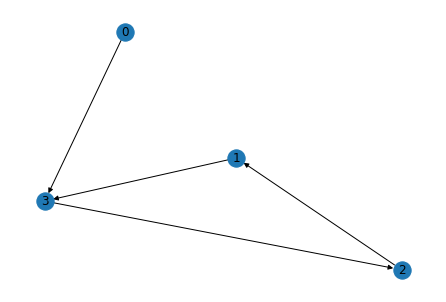

In [2]:
import networkx as nx

in_degrees = [0, 1, 1, 2]
out_degrees = [1, 1, 1, 1]
nkk = {1: {1: 2, 2: 2}}
G = nx.directed_joint_degree_graph(in_degrees, out_degrees, nkk)
nx.draw(G, with_labels=True)

In [1]:
import networkx as nx

def read_graph(name, directed):
    if (directed):
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    with open(name, "r") as lines:
        for line in lines:
            if (line.startswith('#')):
                continue
            a, b = line.split()
            G.add_edge(int(a), int(b))
    return G

twitter_G = read_graph('twitter.txt', directed=True)
enron_G = read_graph('enron.txt', directed=False)
facebook_G = read_graph('facebook.txt', directed=False)

In [13]:
from random import choice, random
from tabulate import tabulate

def cascade(G, retweet_prob = 0.026, candidates = [], table = True, name='network'):
    start = choice(list(G.nodes()))


    S = list()
    S.append(start)
    visited = set()
    retweets = 0

    while S:
        curr = S.pop()

        if curr in visited or curr in candidates:
            continue

        visited.add(curr)
        neighbors = list(G.predecessors(curr))
        for neighbor in neighbors:
            if random() < retweet_prob:
                S.append(neighbor)
                retweets += 1

    N = G.number_of_nodes()
    V = len(visited)
    if table:
        print(name)
        print(
            tabulate(
                [
                    ["RETWEET PROBABILITY", retweet_prob],
                    ["N", N],
                    ["V", V],
                    ["CASCADE SIZE (V / N)", round(V / N, 2)],
                ],
                tablefmt="fancy_grid",
                numalign="left",
            )
        )
    else:
        return str(round(V / N, 2))
        #return retweets

cascade(twitter_G, table=True, name='twitter')
cascade(enron_G, table=True, name='enron')

twitter
╒══════════════════════╤═══════╕
│ RETWEET PROBABILITY  │ 0.04  │
├──────────────────────┼───────┤
│ N                    │ 81306 │
├──────────────────────┼───────┤
│ V                    │ 1     │
├──────────────────────┼───────┤
│ CASCADE SIZE (V / N) │ 0     │
╘══════════════════════╧═══════╛
enron
╒══════════════════════╤═══════╕
│ RETWEET PROBABILITY  │ 0.04  │
├──────────────────────┼───────┤
│ N                    │ 36692 │
├──────────────────────┼───────┤
│ V                    │ 1     │
├──────────────────────┼───────┤
│ CASCADE SIZE (V / N) │ 0     │
╘══════════════════════╧═══════╛


In [37]:
rts = 0
for i in range(10000):
    rt = cascade(twitter_G, retweet_prob=0.026, table=False, name='twitter')
    rts += rt
print(rts / 10000)


1634.7742


In [39]:
print(1634 / 0.026)

62846.15384615385


In [51]:
import pandas as pd

def joint_degree_distribution_directed(G):
    degree_edges = list()
    outer_dict = dict()
    for edge in G.edges:
        out_deg = G.out_degree(edge[0])
        in_deg = G.in_degree(edge[1])
        if (out_deg in outer_dict):
            if (in_deg in outer_dict[out_deg]):
                outer_dict[out_deg][in_deg] += 1
                degree_edges.append([out_deg, in_deg])
            else:
                outer_dict[out_deg][in_deg] = 1
                degree_edges.append([out_deg, in_deg])
        else:
            outer_dict[out_deg] = dict()
            outer_dict[out_deg][in_deg] = 1
            degree_edges.append([out_deg, in_deg])
    df = pd.DataFrame(degree_edges, columns=['out_degree', 'in_degree'])
    return outer_dict, df
    
def joint_degree_distribution_undirected(G):
    degree_edges = list()
    outer_dict = dict()
    for edge in G.edges:
        out_deg = G.degree(edge[0])
        in_deg = G.degree(edge[1])
        if (out_deg in outer_dict and in_deg in outer_dict):
            if (not in_deg in outer_dict[out_deg]):
                outer_dict[out_deg][in_deg] = 0
            if (not out_deg in outer_dict[in_deg]):
                outer_dict[in_deg][out_deg] = 0

        elif (out_deg in outer_dict and not in_deg in outer_dict):
            outer_dict[in_deg] = dict()
            if (not in_deg in outer_dict[out_deg]):
                outer_dict[out_deg][in_deg] = 0
            if (not out_deg in outer_dict[in_deg]):
                outer_dict[in_deg][out_deg] = 0

        elif (in_deg in outer_dict and not out_deg in outer_dict):
            outer_dict[out_deg] = dict()
            if (not in_deg in outer_dict[out_deg]):
                outer_dict[out_deg][in_deg] = 0
            if (not out_deg in outer_dict[in_deg]):
                outer_dict[in_deg][out_deg] = 0
        else:
            outer_dict[out_deg] = dict()
            outer_dict[out_deg][in_deg] = 0
            outer_dict[in_deg] = dict()
            outer_dict[in_deg][out_deg] = 0

        degree_edges.append([out_deg, in_deg])
        
        if (in_deg != out_deg):
            degree_edges.append([in_deg, out_deg])
            outer_dict[out_deg][in_deg] += 1
            outer_dict[in_deg][out_deg] += 1
        else:
            outer_dict[out_deg][in_deg] += 0.5
            outer_dict[in_deg][out_deg] += 0.5

    df = pd.DataFrame(degree_edges, columns=['out_degree', 'in_degree'])
    return outer_dict, df

twitter_jdd, twitter_edge_df = joint_degree_distribution_directed(twitter_G)
enron_jdd, enron_edge_df = joint_degree_distribution_undirected(enron_G)
facebook_jdd, facebook_edge_df = joint_degree_distribution_undirected(facebook_G)


In [5]:
def average_degree_directed(G):
    return G.edges / G.nodes

def average_degree_undirected(G):
    return sum([x[1] for x in G.degree()]) / len(G.nodes)

In [6]:
print(sum([x[1] for x in twitter_G.in_degree()]))

1768149


In [8]:
1695 / 1768149  

0.0009586296177528025

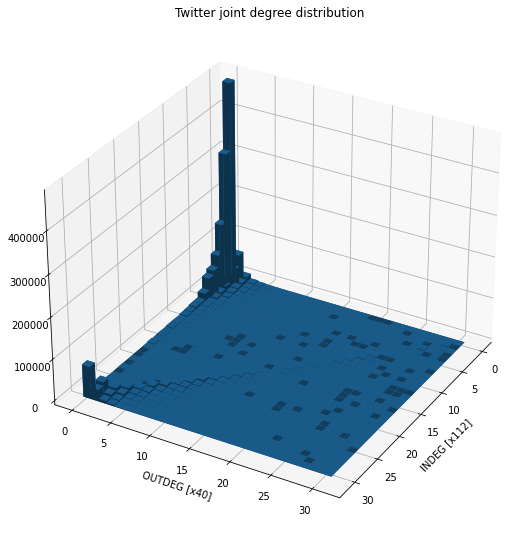

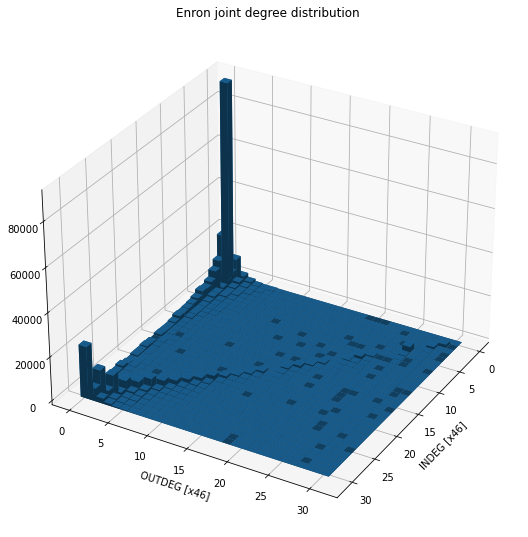

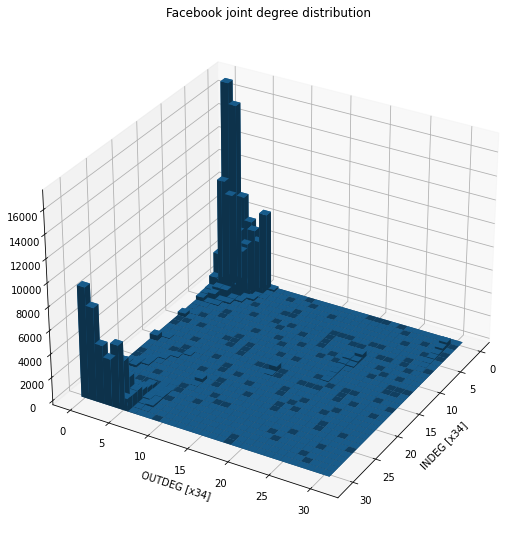

In [52]:
import numpy as np
import matplotlib.pyplot as plt

def plot_jdd(G, jdd, name, directed):
    if (directed):
        max_in = max(list(map(lambda x: x[1], G.in_degree())))
        max_out = max(list(map(lambda x: x[1], G.out_degree())))
    else:
        max_in = max(list(map(lambda x: x[1], G.degree())))
        max_out = max(list(map(lambda x: x[1], G.degree())))

    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(121, projection="3d")

    size = 30
    x_step = max_in // size
    y_step = max_out // size
    _x = np.arange(size + 1)
    _y = np.arange(size + 1)
    _xx, _yy = np.meshgrid(_x, _y)
    x, y = _xx.ravel(), _yy.ravel()
    ax.set_xlabel(f"INDEG [x{x_step}]")
    ax.set_ylabel(f"OUTDEG [x{y_step}]")

    z = np.zeros_like(x)
    for i in jdd.keys():
        for key, val in jdd[i].items():
            a = i // y_step
            b = key // x_step
            z[a + b * size] += val


    bottom = np.zeros_like(z)
    width = depth = 1

    ax.bar3d(x, y, bottom, width, depth, z, shade=True)
    ax.set_title(name + " joint degree distribution")
    ax.azim = 30

    plt.show()

plot_jdd(twitter_G, twitter_jdd, 'Twitter', directed=True)
plot_jdd(enron_G, enron_jdd, 'Enron', directed=False)
plot_jdd(facebook_G, facebook_jdd, 'Facebook', directed=False)

In [6]:
candidates = []
for node in list(twitter_G.nodes()):
    indeg = twitter_G.in_degree(node)
    outdeg = twitter_G.out_degree(node)
    
    _x = indeg // x_step
    _y = outdeg // y_step

    if abs(_x + _y - size) < 10:
        candidates.append(node)

NameError: name 'x_step' is not defined

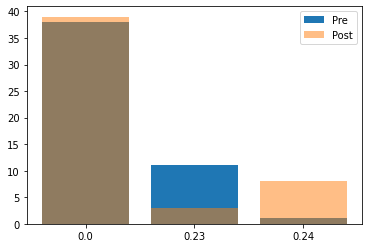

In [43]:
from collections import defaultdict

N = 500
retweet_prob = 0.07
hist_pre = defaultdict(int)
hist_post = defaultdict(int)

for i in range(N):
    hist_pre[cascade(twitter_G, retweet_prob, [], False)] += 1

for i in range(N):
    hist_post[cascade(twitter_G, retweet_prob, candidates, False)] += 1

plt.bar(range(len(hist_pre)), list(hist_pre.values()), align="center", label="Pre")
plt.xticks(range(len(hist_pre)), list(hist_pre.keys()))

plt.bar(range(len(hist_post)), list(hist_post.values()), align="center", alpha=0.5, label="Post")
plt.xticks(range(len(hist_post)), list(hist_post.keys()))
plt.legend()

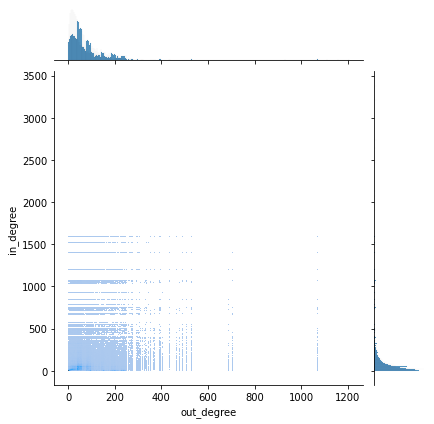

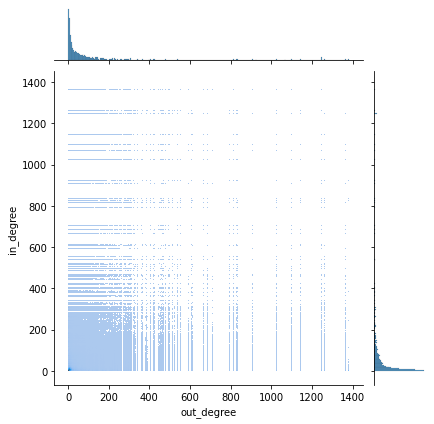

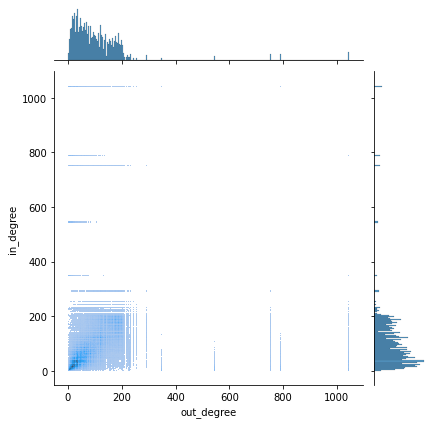

In [39]:
#x = [] 
#y = []
#z = []
#
#for out_key, out_value in jdd.items():
#    for in_key, in_value in jdd[out_key].items():
#        x.append(out_value)
#        y.append(in_value)
#        z.append(jdd[out_key][in_key])

import seaborn as sns

#sns.set(rc={'figure.figsize':(200,20)})
sns.jointplot(data=twitter_edge_df, x="out_degree", y="in_degree", kind="hist")
sns.jointplot(data=enron_edge_df, x="out_degree", y="in_degree", kind="hist")
sns.jointplot(data=facebook_edge_df, x="out_degree", y="in_degree", kind="hist")

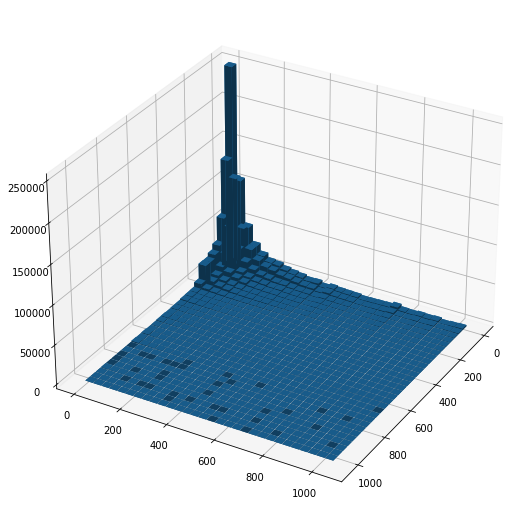

In [73]:

import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


max_in = max(list(map(lambda x: x[1], facebook_G.degree())))
max_out = max(list(map(lambda x: x[1], facebook_G.degree())))

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(121, projection="3d")

#fig = plt.figure()
#ax = fig.add_subplot(projection='3d')
hist, xedges, yedges = np.histogram2d(np.array(twitter_edge_df['out_degree'].tolist()), np.array(twitter_edge_df['in_degree'].tolist()), bins=30, range=[[0, max_in], [0, max_out]])

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

size = 31
x_step = max_in // size
y_step = max_out // size
#_x = np.arange(size + 1)
#_y = np.arange(size + 1)
#_xx, _yy = np.meshgrid(_x, _y)
#xpos, ypos = _xx.ravel(), _yy.ravel()
#ax.set_xlabel(f"INDEG [x{x_step}]")
#ax.set_ylabel(f"OUTDEG [x{y_step}]")

# Construct arrays with the dimensions for the 16 bars.
dx = max_in // size
dy = max_out // size
dz = hist.ravel()
zpos = np.zeros_like(dz)

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, shade=True)
ax.azim = 30

plt.show()


Od tu naprej irrelevant

In [61]:
x = [] 
y = []
z = []

for out_key, out_value in jdd.items():
    for in_key, in_value in jdd[out_key].items():
        x.append(out_value)
        y.append(in_value)
        z.append(jdd[out_key][in_key])

print(x)
print(y)
print(z)

In [85]:
import numpy as np
import matplotlib.pyplot as plt

def inter_hist(ivls, n_bins = 10):
    imin, imax = ivls.min(), ivls.max()
    values = np.arange(imin,imax+1)
    counts = np.zeros(values.shape)
    for i,j in (ivls-imin): 
        counts[i:j+1] += 1
 
    bins = np.arange(imin, imax+1, ((imax-imin)/n_bins))
    plt.hist(values, bins, weights=counts)

intervals = np.array([x,y,z])
inter_hist(intervals)

ValueError: too many values to unpack (expected 2)

In [ ]:
x = [] 
y = []
z = []

for i in range(len(jdd)):
    if (i in jdd):
        x.append()

TypeError: float() argument must be a string or a number, not 'dict'

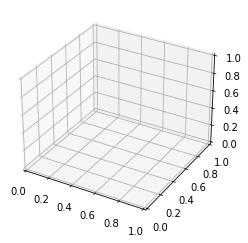

In [56]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, c='y', marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

ValueError: cannot reshape array of size 154911 into shape (3383,1205)

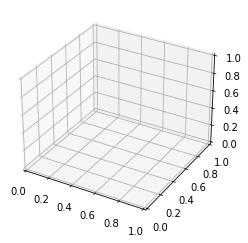

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# setup the figure and axes
#fig = plt.figure(figsize=(8, 3))
#ax1 = fig.add_subplot(121, projection='3d')
#ax2 = fig.add_subplot(122, projection='3d')

# fake data
'''
_x = np.arange(3383)
_y = np.arange(1205)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

top = x + y
bottom = np.zeros_like(top)
width = depth = 1

ax1.bar3d(x, y, bottom, width, depth, top, shade=True)
ax1.set_title('Shaded')
'''
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.reshape(x, (3383, 1205))
y = np.reshape(y, (3383, 1205))
z = np.reshape(z, (3383, 1205))

ax.plot_surface(x, y, z)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()